# SEDD for Perturbation-Seq Prediction

This notebook demonstrates how to use Score-Entropy Discrete Diffusion (SEDD) for perturbation prediction on single-cell RNA-seq data.

## Overview

**Task**: Predict how cells respond to perturbations (gene knockouts, drug treatments, etc.)

**Input**: Control cell expression + Perturbation label  
**Output**: Predicted perturbed cell expression

This implementation is inspired by:
- **STATE** (Arc Institute): Virtual cell model for perturbation prediction
- **SEDD**: Score-Entropy Discrete Diffusion (ICML 2024 Best Paper)

In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


## 1. Generate Synthetic Perturbation-Seq Data

We'll create toy perturbation-seq data with:
- Multiple perturbations (gene knockouts)
- Control cells (unperturbed)
- Perturbed cells with perturbation-specific effects

In [3]:
def create_synthetic_perturbseq(
    num_control_cells: int = 500,
    num_perturbed_per_condition: int = 100,
    num_genes: int = 200,
    num_perturbations: int = 5,
    num_bins: int = 100,
    sparsity: float = 0.7,
    perturbation_effect_size: float = 0.3,
    seed: int = 42
):
    """
    Create synthetic perturbation-seq data.
    
    Returns:
        expression: Discretized expression matrix [num_cells, num_genes]
        pert_labels: Perturbation labels (strings)
        gene_names: Gene names
    """
    rng = np.random.RandomState(seed)
    
    # Gene names
    gene_names = [f'Gene_{i}' for i in range(num_genes)]
    pert_names = ['control'] + [f'KO_Gene_{i}' for i in range(num_perturbations)]
    
    # Generate baseline expression (control cells)
    baseline_mean = rng.uniform(10, 50, num_genes)
    
    # Control cells
    control_expression = rng.poisson(baseline_mean, (num_control_cells, num_genes)).astype(float)
    control_labels = ['control'] * num_control_cells
    
    all_expression = [control_expression]
    all_labels = control_labels
    
    # Generate perturbed cells
    for pert_idx in range(num_perturbations):
        # Each perturbation affects a subset of genes
        affected_genes = rng.choice(num_genes, size=num_genes // 10, replace=False)
        
        # Create perturbation effect
        pert_mean = baseline_mean.copy()
        for gene_idx in affected_genes:
            # Some genes go up, some go down
            direction = rng.choice([-1, 1])
            pert_mean[gene_idx] *= (1 + direction * perturbation_effect_size)
        
        # Generate perturbed cells
        pert_expression = rng.poisson(pert_mean, (num_perturbed_per_condition, num_genes)).astype(float)
        pert_label = pert_names[pert_idx + 1]
        
        all_expression.append(pert_expression)
        all_labels.extend([pert_label] * num_perturbed_per_condition)
    
    # Combine all cells
    expression = np.vstack(all_expression)
    
    # Apply sparsity
    mask = rng.rand(*expression.shape) < sparsity
    expression[mask] = 0
    
    # Discretize expression into bins
    non_zero = expression[expression > 0]
    if len(non_zero) > 0:
        # Log-transform and create bins
        log_expr = np.log1p(expression)
        max_val = log_expr.max()
        
        # Create bins
        discretized = np.zeros_like(expression, dtype=np.int64)
        discretized[expression > 0] = np.clip(
            (log_expr[expression > 0] / max_val * (num_bins - 1)).astype(int) + 1,
            1, num_bins
        )
    else:
        discretized = expression.astype(np.int64)
    
    return discretized, all_labels, gene_names, pert_names


# Generate data
expression, pert_labels, gene_names, pert_names = create_synthetic_perturbseq(
    num_control_cells=500,
    num_perturbed_per_condition=100,
    num_genes=200,
    num_perturbations=5,
    num_bins=100,
    sparsity=0.7,
    seed=42
)

print(f'Expression shape: {expression.shape}')
print(f'Perturbation labels: {len(set(pert_labels))} unique')
print(f'Perturbations: {pert_names}')
print(f'Sparsity: {(expression == 0).mean():.2%}')

# Count cells per perturbation
unique, counts = np.unique(pert_labels, return_counts=True)
for name, count in zip(unique, counts):
    print(f'  {name}: {count} cells')

Expression shape: (1000, 200)
Perturbation labels: 6 unique
Perturbations: ['control', 'KO_Gene_0', 'KO_Gene_1', 'KO_Gene_2', 'KO_Gene_3', 'KO_Gene_4']
Sparsity: 70.00%
  KO_Gene_0: 100 cells
  KO_Gene_1: 100 cells
  KO_Gene_2: 100 cells
  KO_Gene_3: 100 cells
  KO_Gene_4: 100 cells
  control: 500 cells


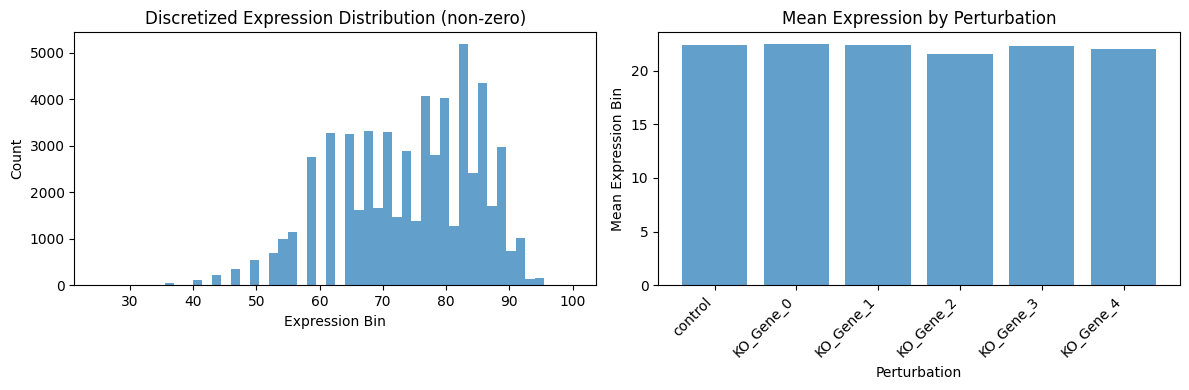

In [4]:
# Visualize expression distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bin distribution
axes[0].hist(expression[expression > 0].flatten(), bins=50, alpha=0.7)
axes[0].set_xlabel('Expression Bin')
axes[0].set_ylabel('Count')
axes[0].set_title('Discretized Expression Distribution (non-zero)')

# Per-perturbation statistics
pert_means = []
for pert in pert_names:
    mask = np.array(pert_labels) == pert
    pert_means.append(expression[mask].mean())

axes[1].bar(range(len(pert_names)), pert_means, alpha=0.7)
axes[1].set_xticks(range(len(pert_names)))
axes[1].set_xticklabels(pert_names, rotation=45, ha='right')
axes[1].set_xlabel('Perturbation')
axes[1].set_ylabel('Mean Expression Bin')
axes[1].set_title('Mean Expression by Perturbation')

plt.tight_layout()
plt.show()

## 2. Create PerturbSeqDataset

The `PerturbSeqDataset` handles control-perturbed cell pairs and perturbation labels.

In [6]:
from sedd.data import PerturbSeqDataset, train_val_split

# Create dataset
NUM_BINS = 100

dataset = PerturbSeqDataset(
    expression=expression,
    pert_labels=pert_labels,
    gene_names=gene_names,
    num_bins=NUM_BINS,
    control_pert_name='control'
)

print(f'\nDataset info:')
print(f'  Perturbed cells: {len(dataset)}')
print(f'  Control cells: {len(dataset.control_expression)}')
print(f'  Number of genes: {dataset.num_genes}')
print(f'  Number of perturbations: {dataset.num_perturbations}')
print(f'  Number of bins: {dataset.num_bins}')

PerturbSeqDataset: 500 perturbed cells, 500 control cells, 6 perturbations

Dataset info:
  Perturbed cells: 500
  Control cells: 500
  Number of genes: 200
  Number of perturbations: 6
  Number of bins: 100


Sample from dataset:
  Control shape: torch.Size([200])
  Perturbation label: 0
  Perturbed shape: torch.Size([200])


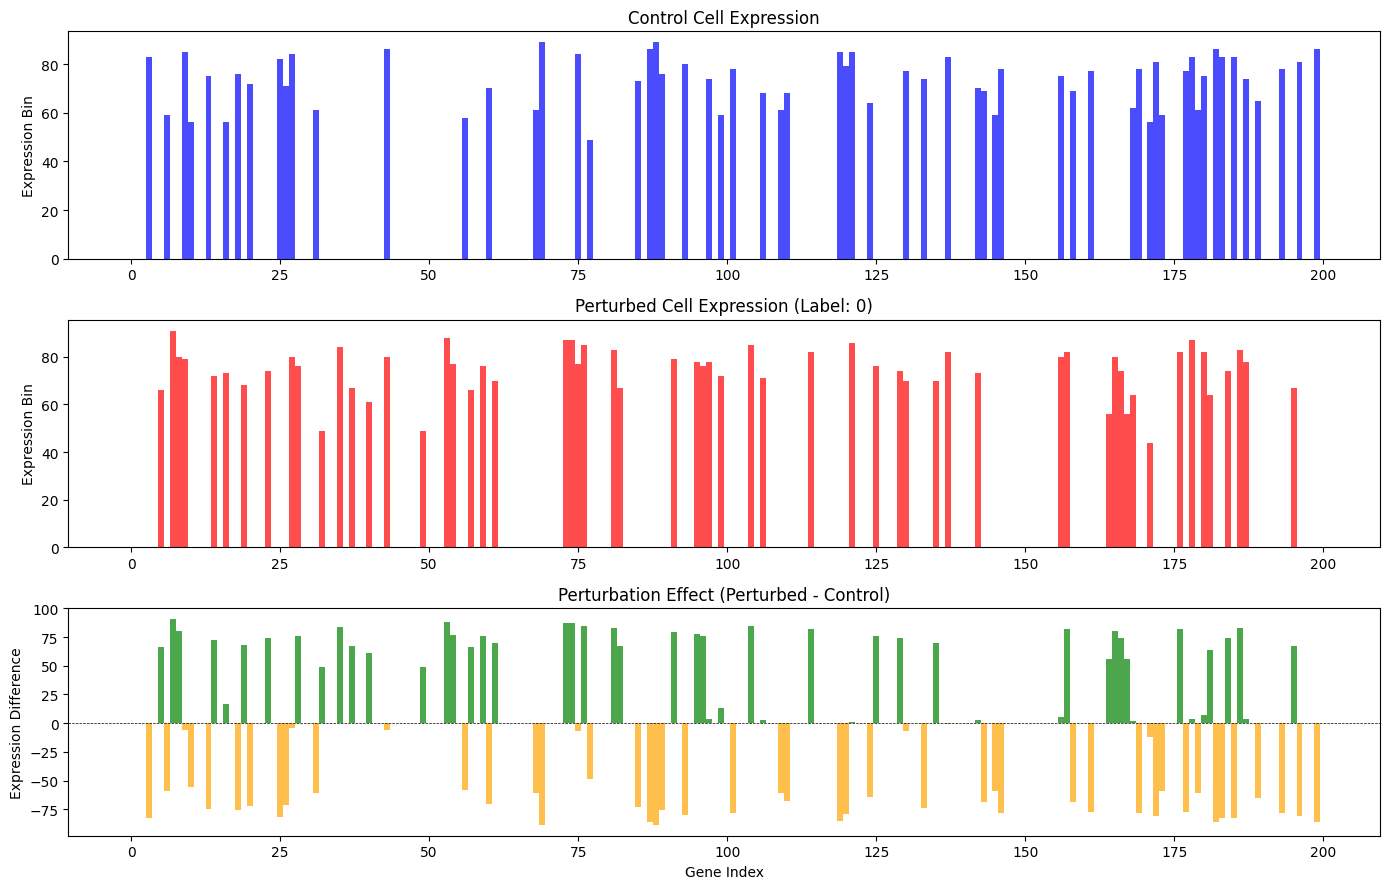

In [7]:
# Inspect a sample from the dataset
control, pert_label, perturbed = dataset[0]

print(f'Sample from dataset:')
print(f'  Control shape: {control.shape}')
print(f'  Perturbation label: {pert_label.item()}')
print(f'  Perturbed shape: {perturbed.shape}')

# Visualize the triplet
fig, axes = plt.subplots(3, 1, figsize=(14, 9))

gene_indices = np.arange(dataset.num_genes)

axes[0].bar(gene_indices, control.numpy(), alpha=0.7, width=1.0, color='blue')
axes[0].set_ylabel('Expression Bin')
axes[0].set_title('Control Cell Expression')

axes[1].bar(gene_indices, perturbed.numpy(), alpha=0.7, width=1.0, color='red')
axes[1].set_ylabel('Expression Bin')
axes[1].set_title(f'Perturbed Cell Expression (Label: {pert_label.item()})')

# Difference
diff = perturbed.numpy() - control.numpy()
colors = ['green' if d > 0 else 'orange' if d < 0 else 'gray' for d in diff]
axes[2].bar(gene_indices, diff, alpha=0.7, width=1.0, color=colors)
axes[2].axhline(0, color='black', linestyle='--', linewidth=0.5)
axes[2].set_xlabel('Gene Index')
axes[2].set_ylabel('Expression Difference')
axes[2].set_title('Perturbation Effect (Perturbed - Control)')

plt.tight_layout()
plt.show()

In [8]:
# Split into train/val
train_dataset, val_dataset = train_val_split(dataset, val_fraction=0.15, seed=42)
print(f'Train size: {len(train_dataset)}, Val size: {len(val_dataset)}')

# Create dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Number of training batches: {len(train_loader)}')
print(f'Number of validation batches: {len(val_loader)}')

Train size: 425, Val size: 75
Number of training batches: 14
Number of validation batches: 3


## 3. Create Perturbation Prediction Model

We use `SEDDPerturbationTransformer` which conditions on perturbation labels.

In [9]:
from sedd.model import SEDDPerturbationTransformerSmall
from sedd.graph import AbsorbingGraph
from sedd.noise import LogLinearNoise

# Model parameters
NUM_GENES = dataset.num_genes
NUM_PERTURBATIONS = dataset.num_perturbations
VOCAB_SIZE = NUM_BINS + 1  # +1 for mask token

# Create model with perturbation conditioning
model = SEDDPerturbationTransformerSmall(
    num_genes=NUM_GENES,
    num_bins=NUM_BINS,
    num_perturbations=NUM_PERTURBATIONS,
    hidden_dim=128,
    num_layers=4,
    num_heads=4,
    dropout=0.1
).to(device)

# Diffusion components
graph = AbsorbingGraph(num_states=VOCAB_SIZE)
noise = LogLinearNoise(eps=1e-3)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f'Model parameters: {num_params:,}')
print(f'\nModel architecture:')
print(f'  Genes: {NUM_GENES}')
print(f'  Bins: {NUM_BINS}')
print(f'  Perturbations: {NUM_PERTURBATIONS}')
print(f'  Hidden dim: 128')
print(f'  Layers: 4')
print(f'  Heads: 4')

Model parameters: 1,900,544

Model architecture:
  Genes: 200
  Bins: 100
  Perturbations: 6
  Hidden dim: 128
  Layers: 4
  Heads: 4


## 4. Train the Model

Training objective: Predict perturbed cell from masked perturbed cell + perturbation label

In [10]:
from sedd.trainer import PerturbationTrainer

# Create trainer
trainer = PerturbationTrainer(
    model=model,
    graph=graph,
    noise=noise,
    device=device,
    gradient_clip=1.0
)

print('Trainer created successfully!')

Trainer created successfully!


In [12]:
# Train for a few epochs (use more epochs for better results)
NUM_EPOCHS = 2
MASK_RATIO = 0.15  # Fraction of genes to mask during training

history = trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    mask_ratio=MASK_RATIO,
    log_interval=1,
    val_interval=1
)

print('\nTraining complete!')

Epoch 1/2: 100%|██████████| 14/14 [01:50<00:00,  7.91s/it, loss=4.5016]


Epoch 1: train_loss=4.5705, val_loss=4.4904


Epoch 2/2: 100%|██████████| 14/14 [01:22<00:00,  5.92s/it, loss=4.1342]


Epoch 2: train_loss=4.3362, val_loss=4.0825

Training complete!


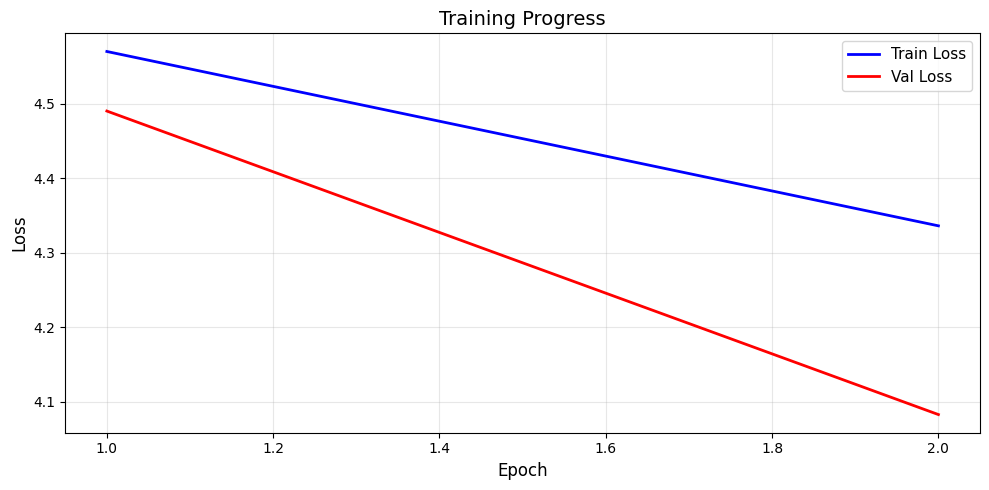

Final train loss: 4.3362
Final val loss: 4.0825
Best val loss: 4.0825


In [13]:
# Plot training curves
fig, ax = plt.subplots(figsize=(10, 5))

epochs = range(1, len(history['train_loss']) + 1)
ax.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Progress', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Final train loss: {history["train_loss"][-1]:.4f}')
print(f'Final val loss: {history["val_loss"][-1]:.4f}')
print(f'Best val loss: {trainer.best_loss:.4f}')

## 5. Inference: Predict Perturbed Cells

Now we test the model's ability to predict how cells respond to perturbations.

In [14]:
from sedd.sampling import EulerSampler

# Set model to eval mode
model.eval()

# Get a test batch
test_control, test_pert_labels, test_perturbed = next(iter(val_loader))
test_control = test_control.to(device)
test_pert_labels = test_pert_labels.to(device)
test_perturbed = test_perturbed.to(device)

print(f'Test batch:')
print(f'  Controls: {test_control.shape}')
print(f'  Pert labels: {test_pert_labels.shape}')
print(f'  True perturbed: {test_perturbed.shape}')

Test batch:
  Controls: torch.Size([32, 200])
  Pert labels: torch.Size([32])
  True perturbed: torch.Size([32, 200])


In [15]:
# Predict perturbed cells using sampling
# We start from all-masked and condition on perturbation labels

with torch.no_grad():
    # Create sampler
    sampler = EulerSampler(
        model=model,
        graph=graph,
        noise=noise,
        num_steps=50,
        device=device,
        temperature=1.0
    )
    
    # Start from all masked
    batch_size = test_control.shape[0]
    x_init = torch.full((batch_size, NUM_GENES), graph.mask_index, device=device)
    
    # Sample with perturbation conditioning
    # Note: Current sampler doesn't take pert_labels, so we'll use a simpler approach
    # For full implementation, we'd need to modify the sampler
    
    # Simple prediction: forward pass with low noise
    sigma = torch.ones(batch_size, device=device) * 0.01
    logits = model(x_init, sigma, test_pert_labels)
    predicted = logits.argmax(dim=-1)

print(f'Predicted perturbed cells: {predicted.shape}')

Predicted perturbed cells: torch.Size([32, 200])


In [ ]:
# Evaluate predictions
with torch.no_grad():
    # Exact match accuracy
    accuracy = (predicted == test_perturbed).float().mean().item()
    print(f'Exact match accuracy: {accuracy:.2%}')
    
    # Mean absolute error
    mae = (predicted - test_perturbed).abs().float().mean().item()
    print(f'Mean Absolute Error: {mae:.2f} bins')
    
    # Within-k accuracy
    for k in [1, 3, 5, 10]:
        within_k = ((predicted - test_perturbed).abs() <= k).float().mean().item()
        print(f'Within {k} bins: {within_k:.2%}')
    

Exact match accuracy: 71.23%
Mean Absolute Error: 21.37 bins
Within 1 bins: 71.23%
Within 3 bins: 71.23%
Within 5 bins: 71.23%
Within 10 bins: 71.23%

Average per-gene correlation: 0.000


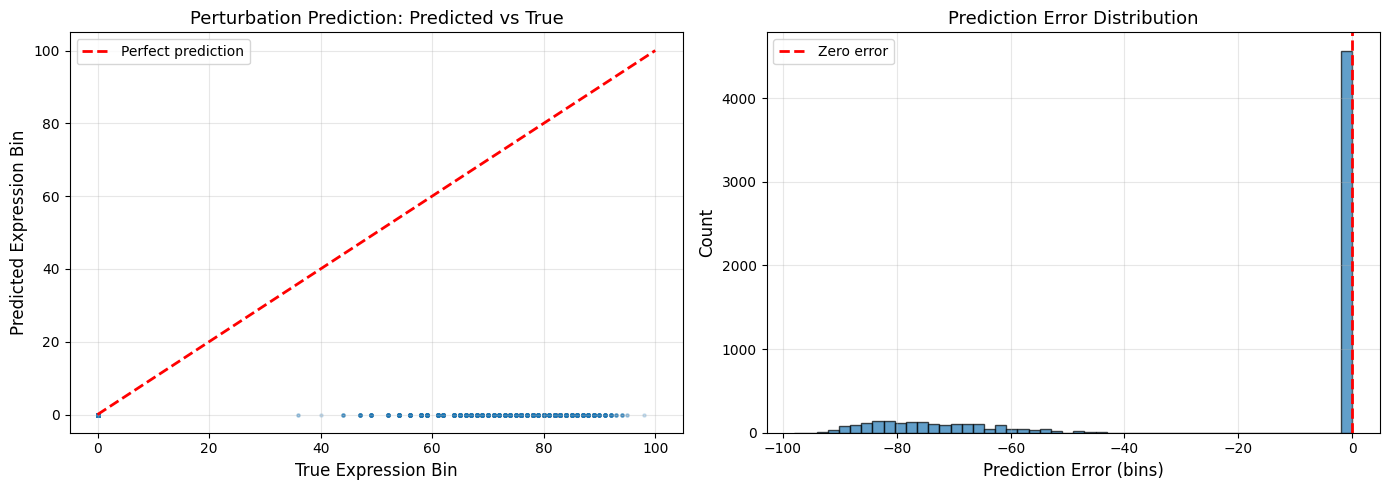

In [17]:
# Visualize predictions vs ground truth
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
true_flat = test_perturbed.cpu().numpy().flatten()
pred_flat = predicted.cpu().numpy().flatten()

axes[0].scatter(true_flat, pred_flat, alpha=0.2, s=5)
axes[0].plot([0, NUM_BINS], [0, NUM_BINS], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('True Expression Bin', fontsize=12)
axes[0].set_ylabel('Predicted Expression Bin', fontsize=12)
axes[0].set_title('Perturbation Prediction: Predicted vs True', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Error distribution
errors = (pred_flat - true_flat)
axes[1].hist(errors, bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(0, color='r', linestyle='--', linewidth=2, label='Zero error')
axes[1].set_xlabel('Prediction Error (bins)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Prediction Error Distribution', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Example Predictions

Let's look at individual cell predictions in detail.

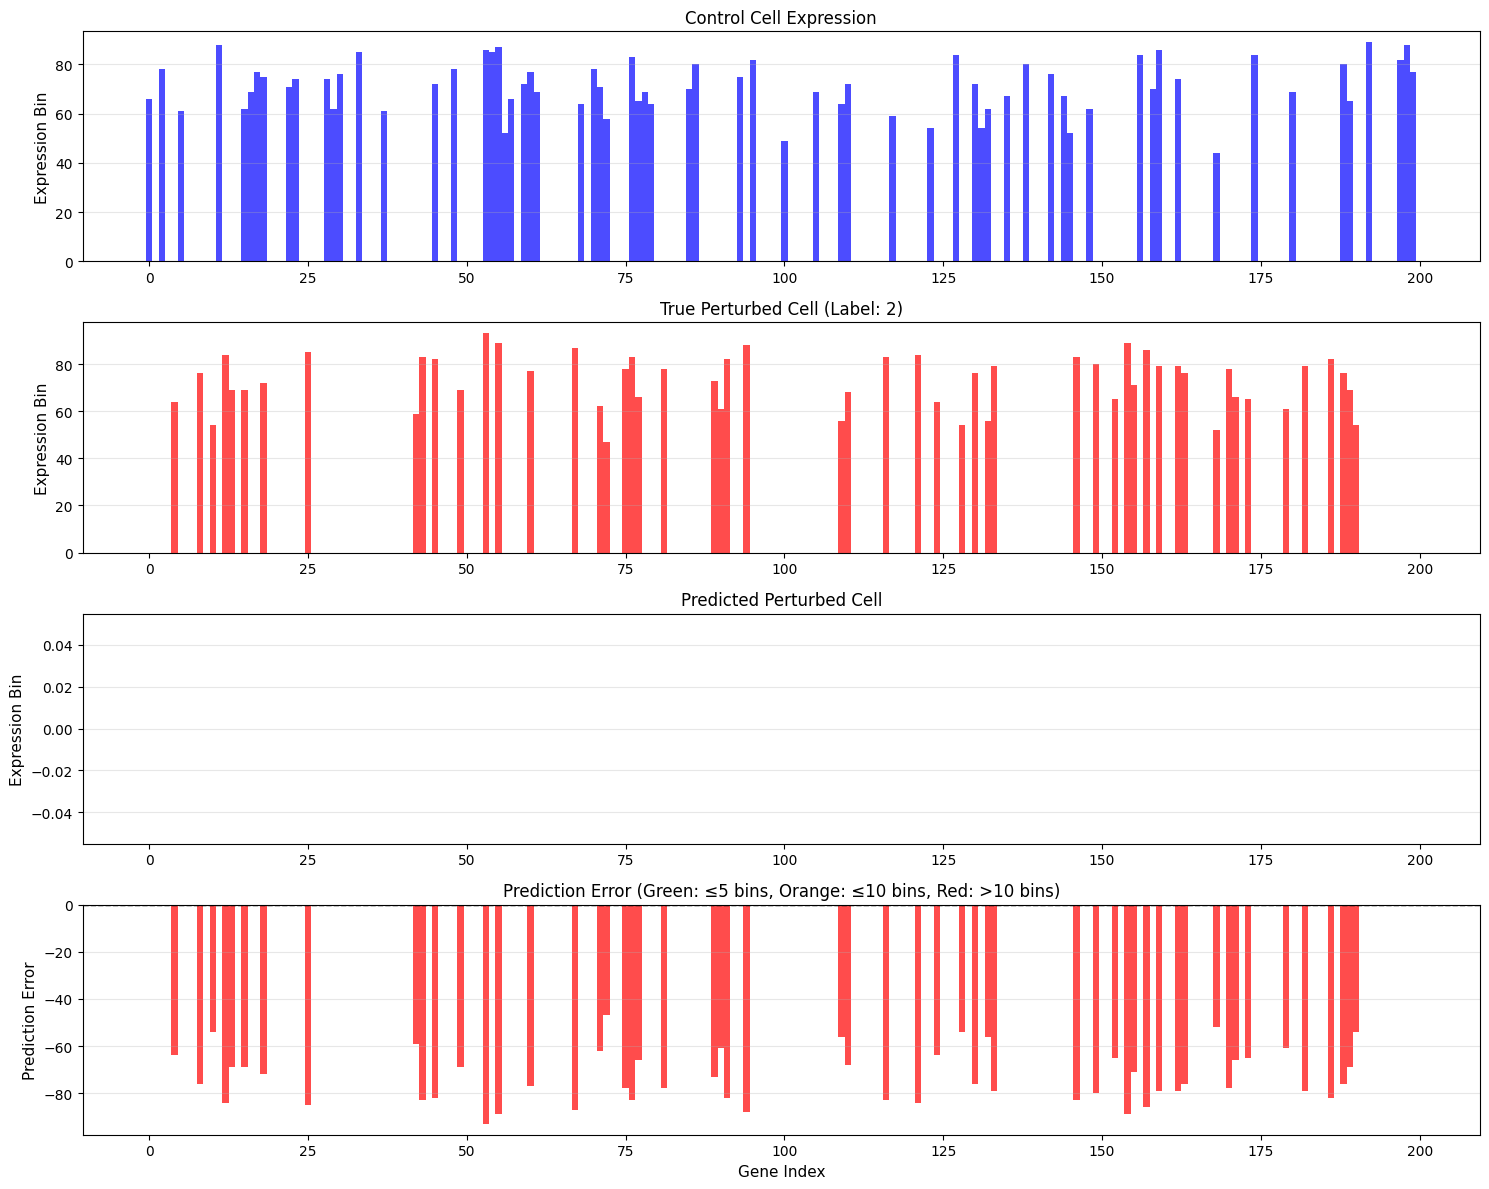


Cell 0 metrics:
  Accuracy: 73.00%
  MAE: 19.70 bins


In [18]:
# Visualize individual predictions
cell_idx = 0

control_cell = test_control[cell_idx].cpu().numpy()
true_perturbed = test_perturbed[cell_idx].cpu().numpy()
pred_perturbed = predicted[cell_idx].cpu().numpy()
pert_label = test_pert_labels[cell_idx].item()

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

gene_indices = np.arange(NUM_GENES)

# Control
axes[0].bar(gene_indices, control_cell, alpha=0.7, width=1.0, color='blue')
axes[0].set_ylabel('Expression Bin', fontsize=11)
axes[0].set_title(f'Control Cell Expression', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')

# True perturbed
axes[1].bar(gene_indices, true_perturbed, alpha=0.7, width=1.0, color='red')
axes[1].set_ylabel('Expression Bin', fontsize=11)
axes[1].set_title(f'True Perturbed Cell (Label: {pert_label})', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

# Predicted perturbed
axes[2].bar(gene_indices, pred_perturbed, alpha=0.7, width=1.0, color='green')
axes[2].set_ylabel('Expression Bin', fontsize=11)
axes[2].set_title(f'Predicted Perturbed Cell', fontsize=12)
axes[2].grid(True, alpha=0.3, axis='y')

# Prediction error
error = pred_perturbed - true_perturbed
colors = ['green' if abs(e) <= 5 else 'orange' if abs(e) <= 10 else 'red' for e in error]
axes[3].bar(gene_indices, error, alpha=0.7, width=1.0, color=colors)
axes[3].axhline(0, color='black', linestyle='--', linewidth=1)
axes[3].set_xlabel('Gene Index', fontsize=11)
axes[3].set_ylabel('Prediction Error', fontsize=11)
axes[3].set_title('Prediction Error (Green: ≤5 bins, Orange: ≤10 bins, Red: >10 bins)', fontsize=12)
axes[3].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Calculate metrics for this cell
cell_acc = (true_perturbed == pred_perturbed).mean()
cell_mae = np.abs(error).mean()
print(f'\nCell {cell_idx} metrics:')
print(f'  Accuracy: {cell_acc:.2%}')
print(f'  MAE: {cell_mae:.2f} bins')

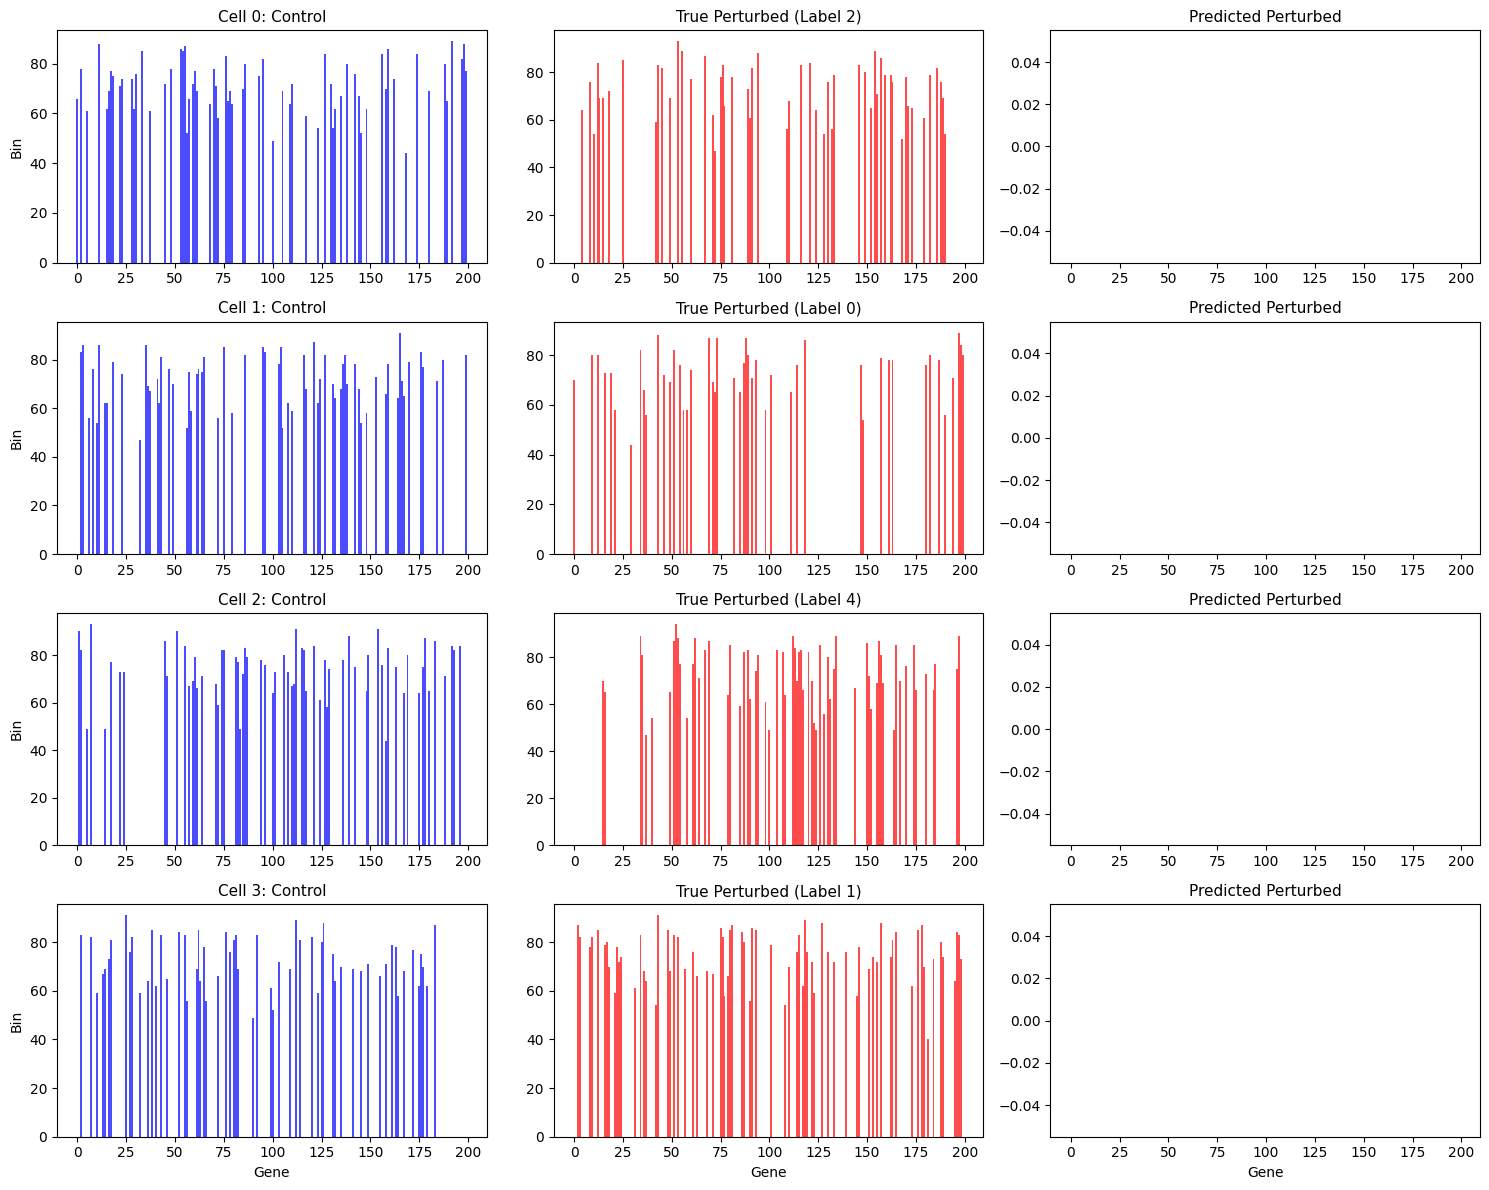

In [19]:
# Compare predictions for multiple cells
num_examples = 4
fig, axes = plt.subplots(num_examples, 3, figsize=(15, 3 * num_examples))

for i in range(num_examples):
    control_cell = test_control[i].cpu().numpy()
    true_cell = test_perturbed[i].cpu().numpy()
    pred_cell = predicted[i].cpu().numpy()
    pert_label = test_pert_labels[i].item()
    
    # Control
    axes[i, 0].bar(range(NUM_GENES), control_cell, alpha=0.7, width=1.0, color='blue')
    axes[i, 0].set_ylabel('Bin', fontsize=10)
    axes[i, 0].set_title(f'Cell {i}: Control', fontsize=11)
    
    # True perturbed
    axes[i, 1].bar(range(NUM_GENES), true_cell, alpha=0.7, width=1.0, color='red')
    axes[i, 1].set_title(f'True Perturbed (Label {pert_label})', fontsize=11)
    
    # Predicted
    axes[i, 2].bar(range(NUM_GENES), pred_cell, alpha=0.7, width=1.0, color='green')
    axes[i, 2].set_title(f'Predicted Perturbed', fontsize=11)
    
    if i == num_examples - 1:
        axes[i, 0].set_xlabel('Gene', fontsize=10)
        axes[i, 1].set_xlabel('Gene', fontsize=10)
        axes[i, 2].set_xlabel('Gene', fontsize=10)

plt.tight_layout()
plt.show()

## 7. Analyze Perturbation-Specific Performance

Let's see how well the model predicts different perturbations.

In [20]:
# Calculate metrics per perturbation
pert_metrics = {}

with torch.no_grad():
    for pert_idx in range(NUM_PERTURBATIONS):
        mask = (test_pert_labels == pert_idx)
        if mask.sum() == 0:
            continue
        
        true_vals = test_perturbed[mask]
        pred_vals = predicted[mask]
        
        acc = (true_vals == pred_vals).float().mean().item()
        mae = (true_vals - pred_vals).abs().float().mean().item()
        within_5 = ((true_vals - pred_vals).abs() <= 5).float().mean().item()
        
        pert_metrics[pert_idx] = {
            'accuracy': acc,
            'mae': mae,
            'within_5': within_5,
            'num_cells': mask.sum().item()
        }

# Display metrics
print('Per-perturbation metrics:\n')
for pert_idx, metrics in pert_metrics.items():
    print(f'Perturbation {pert_idx}:')
    print(f'  Cells: {metrics["num_cells"]}')
    print(f'  Accuracy: {metrics["accuracy"]:.2%}')
    print(f'  MAE: {metrics["mae"]:.2f}')
    print(f'  Within 5 bins: {metrics["within_5"]:.2%}')
    print()

Per-perturbation metrics:

Perturbation 0:
  Cells: 4
  Accuracy: 72.25%
  MAE: 20.65
  Within 5 bins: 72.25%

Perturbation 1:
  Cells: 9
  Accuracy: 70.89%
  MAE: 21.60
  Within 5 bins: 70.89%

Perturbation 2:
  Cells: 7
  Accuracy: 71.29%
  MAE: 21.22
  Within 5 bins: 71.29%

Perturbation 3:
  Cells: 5
  Accuracy: 70.70%
  MAE: 21.94
  Within 5 bins: 70.70%

Perturbation 4:
  Cells: 7
  Accuracy: 71.43%
  MAE: 21.23
  Within 5 bins: 71.43%



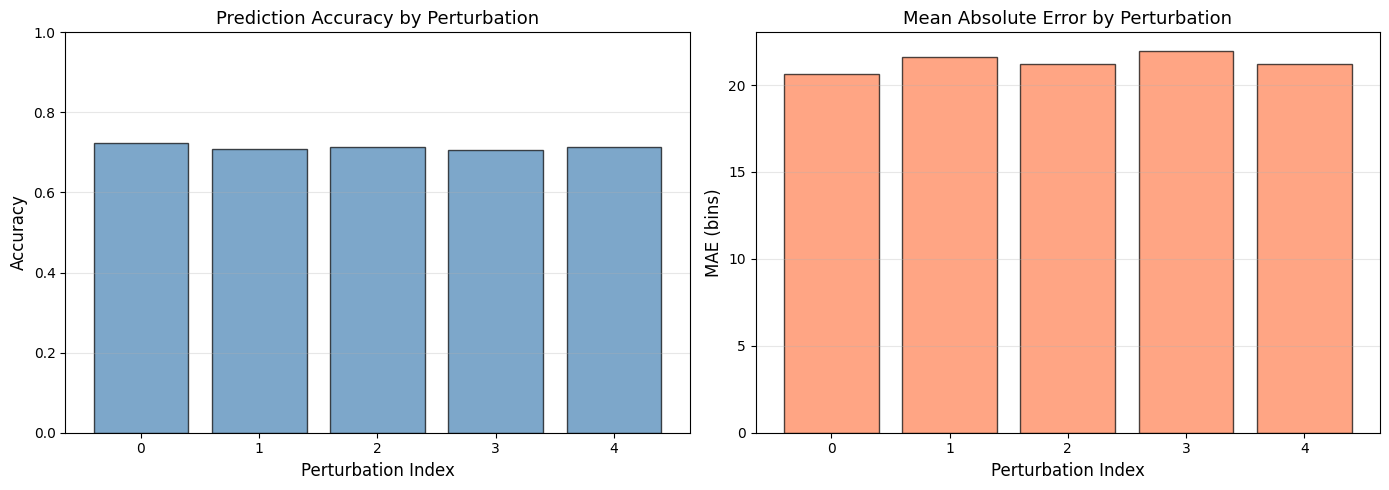

In [21]:
# Visualize per-perturbation performance
if pert_metrics:
    pert_indices = list(pert_metrics.keys())
    accuracies = [pert_metrics[i]['accuracy'] for i in pert_indices]
    maes = [pert_metrics[i]['mae'] for i in pert_indices]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].bar(pert_indices, accuracies, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0].set_xlabel('Perturbation Index', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Prediction Accuracy by Perturbation', fontsize=13)
    axes[0].set_ylim([0, 1])
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # MAE
    axes[1].bar(pert_indices, maes, alpha=0.7, color='coral', edgecolor='black')
    axes[1].set_xlabel('Perturbation Index', fontsize=12)
    axes[1].set_ylabel('MAE (bins)', fontsize=12)
    axes[1].set_title('Mean Absolute Error by Perturbation', fontsize=13)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

## 8. Save and Load Model

Save the trained model for later use.

In [22]:
import os

# Create checkpoints directory
os.makedirs('checkpoints', exist_ok=True)

# Save model
trainer.save_checkpoint('checkpoints/demo_perturbseq_model.pt')
print('Model saved to checkpoints/demo_perturbseq_model.pt')

Model saved to checkpoints/demo_perturbseq_model.pt


In [23]:
# Load model (demonstration)
new_model = SEDDPerturbationTransformerSmall(
    num_genes=NUM_GENES,
    num_bins=NUM_BINS,
    num_perturbations=NUM_PERTURBATIONS,
    hidden_dim=128,
    num_layers=4,
    num_heads=4,
    dropout=0.1
).to(device)

new_trainer = PerturbationTrainer(
    model=new_model,
    graph=graph,
    noise=noise,
    device=device
)

new_trainer.load_checkpoint('checkpoints/demo_perturbseq_model.pt')
print(f'Model loaded! Trained for {new_trainer.epoch + 1} epochs.')
print(f'Best validation loss: {new_trainer.best_loss:.4f}')

Model loaded! Trained for 2 epochs.
Best validation loss: 4.0825


/home/b5cc/sanjukta.b5cc/st3/nbs/../sedd/trainer.py:538: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=self.device)
